# Deep learning based burn severity prediction

In [2]:
# Load libraries
import os, glob, random, time, datetime, warnings
import numpy as np

warnings.filterwarnings('ignore') # Ignore warning messages

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Geospatial
import rasterio
from patchify import patchify, unpatchify

# Machine learning
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, recall_score, precision_score,accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split

# Deep learning library (PyTorch)
from models import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
from torch.optim.lr_scheduler import ReduceLROnPlateau # LR Scheduler
from torch.autograd import Variable # For focal loss

import segmentation_models_pytorch

In [3]:
from preprocess import *

#### 1. Load file directories

In [4]:
# Load paths
BASEPATH = "/Users/minho/Documents/GitHub"
data_path = os.path.join(BASEPATH,'data/data_test')

# Input path
s2_path = sorted(glob.glob(os.path.join(data_path, '*s2_aoi*.tif')))
dem_path = sorted(glob.glob(os.path.join(data_path, '*dem*.tif')))
slope_path = sorted(glob.glob(os.path.join(data_path, '*slope*.tif')))
lulc_path = sorted(glob.glob(os.path.join(data_path, '*lulc*.tif')))

# Label path
burn_severity_path = sorted(glob.glob(os.path.join(data_path, '*fire*.tif')))

**Datasets**
- bs = Burn Severity
- dem_aoi = DEM
- 


In [5]:
# Stack images
def open_data(s2_path, dem_path, slope_path, lulc_path, burn_severity_path):

    img_stack = []

    b,g,r,n = rasterio.open(s2_path, 'r').read([1,2,3,4])
    dem = rasterio.open(dem_path, 'r').read([1])[0]
    slope = rasterio.open(slope_path, 'r').read([1])[0]
    ndvi = (n - r) / (n + r + 1e-8) 
    savi = ( (n - r) / (n + r + 0.5) ) * 1.5
    ndwi = (g - n) / (g + n + 1e-8)
    # lulc = rasterio.open(lulc_path, 'r').read([1])[0]
    lulc_img = (rasterio.open(lulc_path, 'r').read([1])[0] / 10).astype(int)

    img = np.dstack((b,g,r,n,dem,slope,ndvi,savi,ndwi, lulc_img))
    lbl = rasterio.open(burn_severity_path, 'r').read([1])[0]

    return img, lbl

# Min-max normalization (Preprocessing)
def minmax(img):
    a = ( img - np.nanmin(img) ) / ( np.nanmin(img) + np.nanmax(img) )
    return a      

def minmax_bands(image):
    rescaled = [minmax(image[:,:,:,i]) for i in range(image.shape[-1])]
    stack = np.stack(rescaled) # [bands, x, y, batches]
    stack = np.rollaxis(stack, 0, 4) # [batches, x, y, bands]

    return stack

# Prepare patches
def prep_data(image, label, patch_size, mode, threshold):
    
    instances,instances_labels, indexes = [],[],[]

    size_x = (image.shape[1] // patch_size) * patch_size  # width to the nearest size divisible by patch size
    size_y = (image.shape[0] // patch_size) * patch_size  # height to the nearest size divisible by patch size
    
    # Extract patches from each image, step=patch_size means no overlap
    step=patch_size
    
    if mode == "train":
        n_bands = image.shape[2]

        if n_bands > 1:            
            image = image[0:size_x, 0:size_y,:]
            patch_img = patchify(image, (patch_size, patch_size, n_bands), step=patch_size)
        else:
            image = image[0:size_x, 0:size_y]
            patch_img = patchify(image, (patch_size, patch_size), step=patch_size)            

    lbl = label[0:size_x, 0:size_y]
    patch_lbl = patchify(lbl, (patch_size, patch_size), step=patch_size)

    patch_lbl[patch_lbl>4] = 0 # Omit any values above 4 (V high severity)
    patch_lbl[patch_lbl==-9999] = 0 # Omit any null values
    labels = patch_lbl

    # iterate over patch axis
    i=0

    for j in range(patch_img.shape[0]):
        for k in range(patch_img.shape[1]):

            single_img = patch_img[j, k] # patches are located like a grid. use (j, k) indices to extract single patched image
            single_lbl = labels[j, k] # patches are located like a grid. use (j, k) indices to extract single patched image
            
            lbl = single_lbl
            count, num = np.unique(lbl, return_counts=True)
            
            if num[0]/patch_size**2 < threshold:
            # if len(count) > 1 and 0 in count and num[0]/patch_size**2 < threshold: 

                instances.append(single_img[0])
                instances_labels.append(single_lbl)
            
            i += 1 # Increase counter

    indexes.append(len(instances))

    return instances, instances_labels, indexes

In [8]:
# Input parameters
patch_size = 32
mode = 'train'
threshold = 0.1
_seed = 42

# DL parameters
_batch_size = 64
_train_fraction = 0.2
_test_fraction = 0.25
_epochs = 100
patience = 20
lr = 0.001
gamma_test=2; alpha_test=0.25 # Focal & Tversky loss
plot_decision = True

In [9]:
# Load image stacks with label
full_stack, indexes, labels_list = [],[],[]

# Loop through all burn severity samples and patchify
for i in range(len(burn_severity_path)):

    # Open stacked image and label (for one instance)
    img_stack, label = open_data(s2_path[i], dem_path[i], slope_path[i], lulc_path[i], burn_severity_path[i])

    # Prepare data
    imgs, labels, idxs = prep_data(img_stack,label,patch_size, mode, threshold)
    imgs = np.array(imgs)
    labels = np.array(labels)

    # Expand 1-band images to 4D tensors
    if len(np.array(imgs).shape) < 4: 
        imgs = np.expand_dims(imgs, -1)
    
    full_stack.append(imgs)
    indexes.append(idxs[0])
    labels_list.append(labels)

# Stack
imgs = np.concatenate((full_stack),axis=0)
labels = np.concatenate((labels_list),axis=0)

# Preprocess inputs
imgs = imgs.astype(float)
imgs[imgs==-9999]= np.nan
nan_mask = np.isnan(imgs)
imgs[nan_mask] = 0

# Preprocess labels
labels = labels.astype(float)
labels[labels==-9999] = np.nan
nan_mask = np.isnan(labels)
labels[nan_mask] = 0

In [10]:
# Dataset split
X_test = None
X_train, X_val, Y_train, Y_val = train_test_split(imgs, labels, test_size=_train_fraction, random_state=_seed)
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=_test_fraction, random_state=_seed)

# Minmax Scaling
# X_train = minmax_bands(X_train)
# X_val = minmax_bands(X_val)

print("TRAINING :", X_train.shape, Y_train.shape)
print("TESTING :", X_test.shape, Y_test.shape)
print("VALIDATION :", X_val.shape, Y_val.shape)

TRAINING : (9652, 32, 32, 10) (9652, 32, 32)
TESTING : (3218, 32, 32, 10) (3218, 32, 32)
VALIDATION : (3218, 32, 32, 10) (3218, 32, 32)


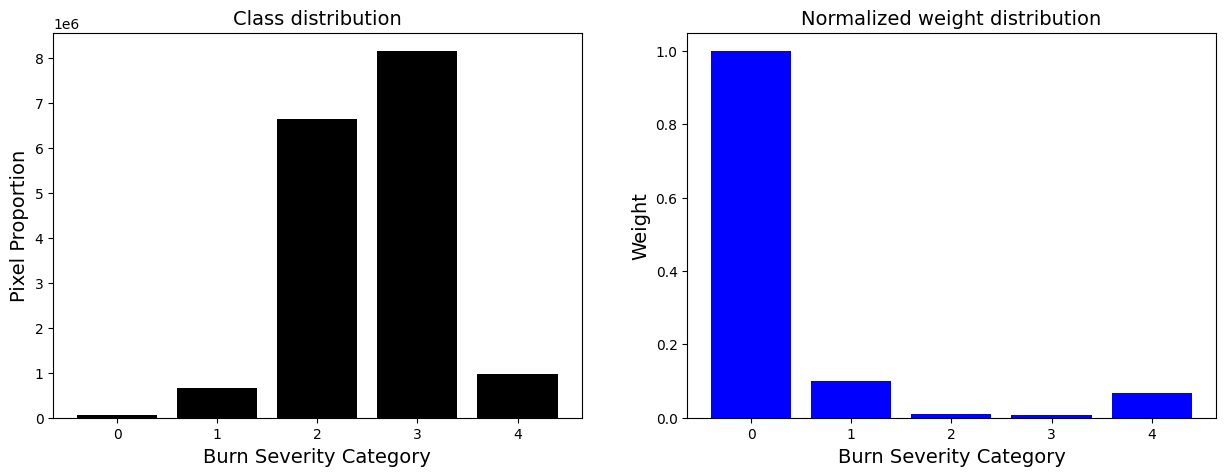

In [11]:
# Normalized weights for class imbalance
num,count = np.unique(labels, return_counts = True) # _labels for one-hot

# max_class_count = count[np.argmax(count)]
weights = sum(count) / count
weights /= max(weights)
# weights[0] = 0

fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].bar(num, count, color='k', linewidth=2)
ax[0].set_xticks(num)
ax[0].set_title('Class distribution', size = 14)
ax[0].set_xlabel('Burn Severity Category', size=14)
ax[0].set_ylabel('Pixel Proportion', size=14)

ax[1].bar(np.arange(0,5,1), weights, color='b')
ax[1].set_xticks(num)
ax[1].set_title('Normalized weight distribution', size = 14)
ax[1].set_xlabel('Burn Severity Category', size=14)
ax[1].set_ylabel('Weight', size=14)

plt.show()

weights = np.append(0, weights) # normalized

#### 2. Preprocess inputs

In [12]:
# Converting training images into torch format
X_train_res = np.rollaxis(X_train, 3,1)
X_val_res = np.rollaxis(X_val, 3,1)

# Reshape and prepare tensors for Train and Validation sets
train_x = X_train_res.reshape(X_train_res.shape[0], X_train_res.shape[1], X_train_res.shape[2], X_train_res.shape[3])
train_x  = torch.from_numpy(X_train_res).float()
val_x = X_val_res.reshape(X_val_res.shape[0], X_val_res.shape[1], X_val_res.shape[2], X_val_res.shape[3])
val_x  = torch.from_numpy(X_val_res).float()

# Create Test set
if X_test is not None:
    X_test = minmax_bands(X_test)
    X_test_res = np.rollaxis(X_test, 3,1)
    test_x = X_test_res.reshape(X_test_res.shape[0], X_test_res.shape[1], X_test_res.shape[2], X_test_res.shape[3])
    test_x  = torch.from_numpy(X_test_res).float()
    # test_y = Y_test
    test_y = Y_test.astype(int)
    test_y = torch.from_numpy(Y_test)
    print("TESTING :", test_x.shape, test_y.shape)
    del X_test_res

# Converting the target (Labels) into torch format
train_y = Y_train.astype(int)
train_y = torch.from_numpy(Y_train)
val_y = Y_val.astype(int)
val_y = torch.from_numpy(Y_val)

# Shape of training data
print("TRAINING :", train_x.shape, train_y.shape)
print("VALIDATION :", val_x.shape, val_y.shape)

del X_train_res, X_val_res

TESTING : torch.Size([3218, 10, 32, 32]) torch.Size([3218, 32, 32])
TRAINING : torch.Size([9652, 10, 32, 32]) torch.Size([9652, 32, 32])
VALIDATION : torch.Size([3218, 10, 32, 32]) torch.Size([3218, 32, 32])


Dataset for dataloaders

In [13]:
# Dataset for Dataloaders
class tensorDataset(Dataset):
    
    def __init__(self, images, masks, augmentations=None):
        self.images = images
        self.masks  = masks
        self.augmentations = augmentations

    def __getitem__(self, index):
        image = self.images[index]
        mask = self.masks[index]

        if self.augmentations is not None:
            # Apply augmentations to both image and mask
            random.seed(_seed)
            image = self.augmentations(image)
            mask = self.augmentations(mask)

        # Turn on gradient for image
        img = image.detach().clone().requires_grad_(True)
        mask = mask.long()
        
        return img, mask
    
    def __len__(self):
        return len(self.images)

# Augmentations
augmentations = T.Compose([
    # T.RandomResizedCrop(),
    T.RandomHorizontalFlip(),  # Randomly flip horizontally
    T.RandomVerticalFlip(),    # Randomly flip vertically
])

#### Pytorch-lightning

In [37]:
# Pytorch-Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
# from segmentation_models_pytorch import UnetPlusPlus
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss, TverskyLoss
from segmentation_models_pytorch.metrics import get_stats, iou_score, accuracy, precision, recall, f1_score

# Input parameters
if not torch.cuda.is_available():
    device=torch.device("cpu")
    print("Current device:", device)
else:
    device=torch.device("cuda")
    print("Current device:", device, "- Type:", torch.cuda.get_device_name(0))

n_classes = len(count)
dec_name = "unet"
enc_name = "efficientnet-b4"

Current device: cuda - Type: NVIDIA GeForce RTX 2080 Ti


In [38]:
class SegmentationModel(pl.LightningModule):
    def __init__(self,arch='unet',enc_name='none', loss=None, encoder_depth=5, decoder_channels=[256,128,64,32,16], in_channels=6,n_classes=5, lr=0.0001):
        super().__init__()

        if enc_name == 'none':
            self.model = smp.create_model(arch,
                    in_channels = in_channels,
                    activation="softmax",
                    classes = n_classes).to(device)
        elif enc_name == 'unet':
            self.model = smp.create_model(arch,
                        encoder_name = enc_name,
                        encoder_depth = encoder_depth,
                        in_channels = in_channels,
                        encoder_weights = None,
                        activation="softmax",
                        decoder_channels = decoder_channels,
                        classes = n_classes).to(device)
        else:
            self.model = smp.create_model(arch,
                        encoder_name = enc_name,
                        in_channels = in_channels,
                        encoder_weights = None,
                        activation="softmax",
                        classes = n_classes).to(device)

        # Set loss function
        if loss ==  1:
            self.criterion = DiceLoss(mode="multiclass", from_logits=True)
        elif loss == 2:
            self.criterion = FocalLoss(mode="multiclass")
        elif loss == 3:
            self.criterion = TverskyLoss(mode="multiclass", from_logits=True)

        self.loss=loss
        self.n_classes = n_classes
        self.lr = lr

    def forward(self, inputs, targets=None):
        
        outputs = self.model(inputs)
        if targets is not None:
            if self.loss == 2: # Only for focal loss
                targets = targets.squeeze(1)
            loss = self.criterion(outputs, targets.long()).to(device)
            # targets_cpu = targets.cpu().detach().numpy()
            # outputs_cpu = outputs.cpu().detach().numpy()
            # tp, fp, fn, tn = get_stats(np.expand_dims(np.argmax(outputs_cpu, axis=1),1).astype(int), np.expand_dims(targets_cpu, 1), mode='multiclass', num_classes=n_classes)            
            outs = torch.argmax(outputs, 1)
            tp, fp, fn, tn = get_stats(outs, targets.long().squeeze(1), mode='multiclass', num_classes=self.n_classes)
            
            metrics = {
                "Accuracy": accuracy(tp, fp, fn, tn, reduction="micro-imagewise"),
                "IoU": iou_score(tp, fp, fn, tn, reduction="micro-imagewise"),
                "Precision": precision(tp, fp, fn, tn, reduction="micro-imagewise"),
                "Recall": recall(tp, fp, fn, tn, reduction="micro-imagewise"),
                "F1score": f1_score(tp, fp, fn, tn, reduction="micro-imagewise")
            }
            return loss, metrics, outputs
        else: 
            return outputs

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.model.parameters(), lr = self.lr)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max = 10)
        return [opt], [sch]

    def training_step(self, batch, batch_idx):
        images, masks = batch
        masks=masks.long()

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "train/Loss": loss,
            "train/IoU": metrics['IoU'],
            "train/Accuracy": metrics['Accuracy'],
            "train/Precision": metrics['Precision'],
            "train/Recall": metrics['Recall'],
            "train/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        masks=masks.long()
        
        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "val/Loss": loss,
            "val/IoU": metrics['IoU'],
            "val/Accuracy": metrics['Accuracy'],
            "val/Precision": metrics['Precision'],
            "val/Recall": metrics['Recall'],
            "val/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "test/Loss": loss,
            "test/IoU": metrics['IoU'],
            "test/Accuracy": metrics['Accuracy'],
            "test/Precision": metrics['Precision'],
            "test/Recall": metrics['Recall'],
            "test/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

class SegmentationDataModule(pl.LightningDataModule):
    def __init__(self, train_x, train_y, val_x, val_y, test_x, test_y, augmentations, seed, batch_size):
        super().__init__()
        self.train_x = train_x
        self.train_y = train_y
        self.val_x = val_x
        self.val_y = val_y
        self.test_x = test_x
        self.test_y = test_y
        self.batch_size = batch_size
        self.seed = seed
        self.augmentations = augmentations

    def setup(self, stage=None):
        self.train_dataset = tensorDataset(self.train_x, self.train_y, augmentations=self.augmentations)
        self.val_dataset = tensorDataset(self.val_x, self.val_y, augmentations=self.augmentations)
        self.test_dataset = tensorDataset(self.test_x, self.test_y, augmentations=self.augmentations)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, drop_last=True, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size//2, drop_last=True, shuffle=False, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size//2, drop_last=True, shuffle=False, num_workers=4)


def checkpoint_params(dirpath="checkpoints",filename="best-checkpoint"):

    # Set checkpoints
    checkpoint_callback = ModelCheckpoint(
        dirpath=dirpath,
        filename=filename,
        save_top_k=1,
        verbose=True,
        monitor="val/Loss",
        mode="min"
    )
    return checkpoint_callback

def log_params(dirpath="lightning_logs",logname="log",patience=15):

    logger = CSVLogger(dirpath, name=logname)
    early_stopping_callback = EarlyStopping(monitor="val/Loss", mode="min", patience=patience)

    return logger, early_stopping_callback

# Set model
encoder_depth = 5
dim = 64
in_channels=10
out_channels=5
_lr = lr

decoder_channels = np.ones(encoder_depth) * dim     # Create decoder channels (based on largest "dim" size from args)
decoder_channels = [int(decoder_channels[i+1] / 2**(i+1)) for i in range(len(decoder_channels)-1)]

model = SegmentationModel(arch=dec_name,loss=2,enc_name=enc_name,encoder_depth=encoder_depth, decoder_channels=decoder_channels,in_channels=in_channels,n_classes=out_channels, lr=_lr)

# Set directory to save
_timename = "log_" + datetime.datetime.now().strftime('%Y%m%d')+"_"+enc_name+"_"+dec_name
timename = str(_timename)
if not os.path.exists(os.path.join('lightning_logs', timename)):    
    os.makedirs(os.path.join('lightning_logs', timename))

checkpoint_callback = checkpoint_params(dirpath="checkpoints",filename=timename)
logger, early_stopping_callback = log_params(dirpath="lightning_logs",logname=timename,patience=patience)

# Setup trainer
trainer = pl.Trainer(
    logger=logger,
    log_every_n_steps=31,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=_epochs,
    accelerator="gpu",
    devices=1,
    num_sanity_val_steps=0,
    )

# Create data module for PL
data_module = SegmentationDataModule(train_x, train_y, val_x, val_y, test_x, test_y, augmentations=augmentations, seed=_seed, batch_size=_batch_size)
data_module.setup()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [33]:
# trainer.fit(model, data_module)

In [34]:
# trainer.test(model, data_module)

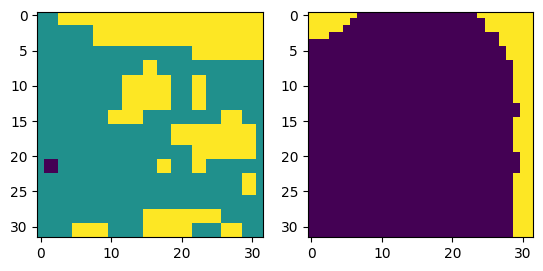

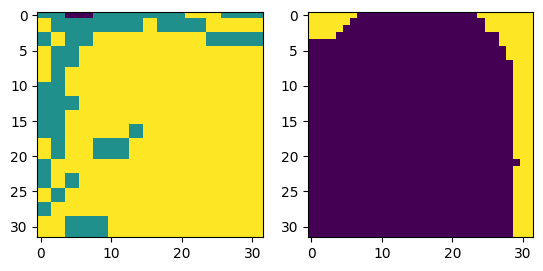

In [39]:
checkpoint = torch.load('/home/minho/fires/caltrans/src/checkpoints/log_20230629_efficientnet-b4_unet.ckpt')
model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_states'])
epoch = checkpoint['epoch']
# loss = checkpoint['loss']
model.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

y_hat = model(test_x[:100].to(device))
_, h = torch.max(y_hat,1)

for i in range(2):
    fig,ax=plt.subplots(1,2)
    ax[0].imshow(test_y[i])
    ax[1].imshow(h.cpu()[i])

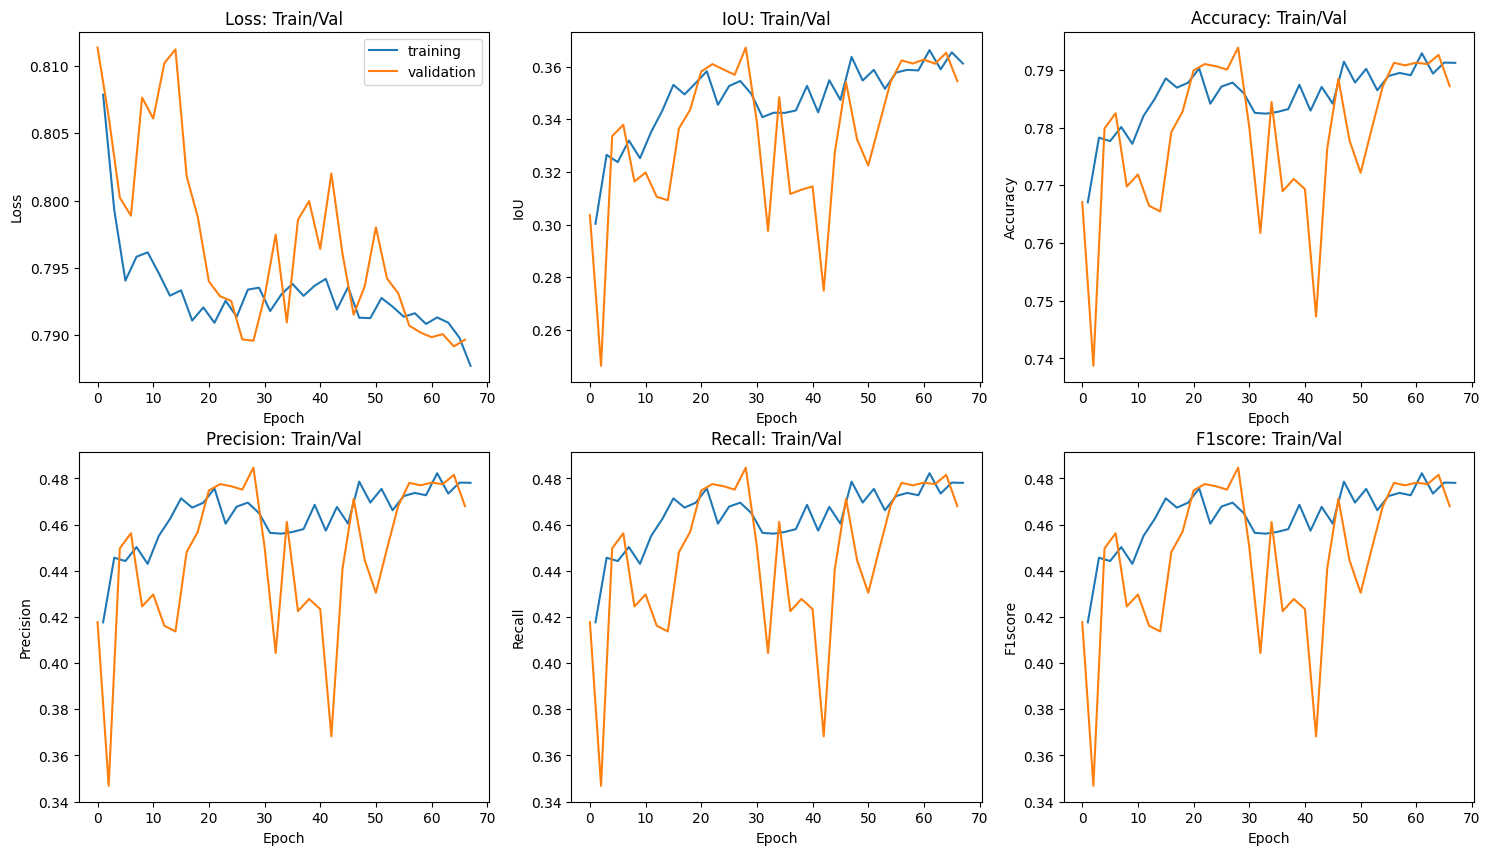

In [27]:
import pandas as pd

metrics = pd.read_csv("/home/minho/fires/caltrans/src/lightning_logs/log_20230629_efficientnet-b0_unetplusplus/version_3/metrics.csv")
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 10))

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
names = ['Loss', 'IoU', 'Accuracy', 'Precision', 'Recall', 'F1score']

for axis, name in zip(axes, names):
    axis.plot(metrics[f'train/{name}'].dropna())
    axis.plot(metrics[f'val/{name}'].dropna())
    axis.set_title(f'{name}: Train/Val')
    axis.set_ylabel(name)
    axis.set_xlabel('Epoch')
    ax1.legend(['training', 'validation'], loc="upper right")

In [ ]:
# Augmentations
augmentations = T.Compose([
    # T.RandomResizedCrop(),
    T.RandomHorizontalFlip(),  # Randomly flip horizontally
    T.RandomVerticalFlip(),    # Randomly flip vertically
])

In [ ]:
# Set Dataset and DataLoaders

# Train, 
train_dataset = tensorDataset(train_x, train_y, augmentations=augmentations)
train_dataloader = DataLoader(train_dataset, batch_size=_batch_size, drop_last=True, shuffle=True)

# Validation
val_dataset = tensorDataset(val_x, val_y, augmentations=augmentations)
val_dataloader = DataLoader(val_dataset, batch_size=_batch_size, drop_last=True, shuffle=False)

# Test
if X_test is not None:
    test_dataset = tensorDataset(test_x, test_y, augmentations=augmentations)
    test_dataloader = DataLoader(test_dataset, batch_size=8, drop_last=True, shuffle=False)

In [ ]:
class WeightedFocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True, class_weights=None, ignore_index=0):
        super(WeightedFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)):
            self.alpha = torch.Tensor([alpha, 1 - alpha])
        if isinstance(alpha, list):
            self.alpha = torch.Tensor(alpha)
        self.size_average = size_average
        self.class_weights = class_weights
        self.ignore_index = ignore_index

    def forward(self, input, target):
        target = target * ((target != self.ignore_index) & (target != 15)).long()

        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1, 2)  # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1, input.size(2))  # N,H*W,C => N*H*W,C
        target = target.view(-1, 1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.data.view(-1))
            logpt = logpt * Variable(at)

        if self.class_weights is not None:
            class_weights = self.class_weights.type_as(input)
            weights = class_weights.gather(0, target.view(-1))
            logpt = logpt * weights

        loss = -1 * (1 - pt) ** self.gamma * logpt
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()


class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, smooth=1e-7, n_classes=None, ignore_index=0):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth
        self.ignore_index = ignore_index
        self.n_classes = n_classes

    def forward(self, input, target):
        target = target * ((target != self.ignore_index) & (target != 15)).long()
        target = F.one_hot(target, self.n_classes+1).permute(0, 3, 1, 2).float()
        input = F.softmax(input, dim=1)

        tp = torch.sum(input * target, dim=(2, 3))
        fp = torch.sum(input * (1 - target), dim=(2, 3))
        fn = torch.sum((1 - input) * target, dim=(2, 3))

        tversky = (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
        loss = 1 - tversky.mean()

        return loss

class FocalLoss(nn.CrossEntropyLoss):
    ''' Focal loss for classification tasks on imbalanced datasets '''

    def __init__(self, gamma, alpha=None, ignore_index=0, reduction='none'):
        super().__init__(weight=alpha, ignore_index=ignore_index, reduction=reduction)
        self.gamma = gamma

    def forward(self, input_, target):
        cross_entropy = super().forward(input_, target)
        # Temporarily mask out ignore index to '0' for valid gather-indices input.
        # This won't contribute final loss as the cross_entropy contribution
        # for these would be zero.
        target = target * (target != self.ignore_index).long()
        input_prob = torch.gather(F.softmax(input_, 1), 1, target.unsqueeze(1))
        loss = torch.pow(1 - input_prob, self.gamma) * cross_entropy

        if self.reduction == 'mean':
            return torch.mean(loss)
        elif self.reduction == 'sum':
            return torch.sum(loss)
        else:
            return loss

class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, gamma=1.0, ignore_index=None):
        super(FocalTverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.ignore_index = ignore_index

    def forward(self, input, target):
        if self.ignore_index is not None:
            valid_mask = (target != self.ignore_index)
            target = target * valid_mask
            input = input * valid_mask.unsqueeze(1)

        input = input.sigmoid()

        true_positives = torch.sum(input * target)
        fps = torch.sum(input * (1 - target))
        fns = torch.sum((1 - input) * target)
        
        tversky = (true_positives + self.alpha) / (true_positives + self.alpha * self.beta + self.gamma * fns + fps + 1e-10)
        focal_tversky = torch.pow(1 - tversky, self.gamma)

        loss = -torch.log(tversky)

        if self.ignore_index is not None:
            loss = loss[target != self.ignore_index]

        return loss.mean()

class EarlyStopping():

    def __init__(self, patience, min_delta=0):

        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"### INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('### INFO: Early stopping')
                self.early_stop = True

In [ ]:
# Main Training Loop
def fit(model, train_dl, optimizer, criterion, aux, device):

    y_true = []
    y_pred = []

    oa_list, f1_list, precision_list, recall_list = [],[],[],[]
    oa_list2 = []
    total_train_losses,total_train_accuracy,total_train_f1 = [],[],[]

    model.train()
    train_loss = 0.0
    total_samples= 0
    train_corrects = 0

    for i, (inputs, labels) in enumerate(train_dl):
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds + 1
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)
        train_corrects += torch.sum(preds == labels.data)

        # # Convert y_true and y_pred to numpy arrays
        y_true = np.array(labels.cpu().numpy())
        y_pred = np.array(preds.cpu().numpy())
        y_true = y_true.reshape(y_true.shape[0], -1)
        y_pred = y_pred.reshape(y_pred.shape[0], -1)     

        # # Convert to multilabel-indicator format
        mlb = MultiLabelBinarizer()
        y_true_multilabel = mlb.fit_transform(y_true)
        y_pred_multilabel = mlb.transform(y_pred)

        # Compute precision, recall, and F1 score
        overall_acc = accuracy_score(y_true_multilabel.flatten(), y_pred_multilabel.flatten())

        precision = precision_score(y_true_multilabel, y_pred_multilabel, average='weighted', zero_division=0)
        recall = recall_score(y_true_multilabel, y_pred_multilabel, average='weighted', zero_division=0)
        f1 = f1_score(y_true_multilabel, y_pred_multilabel, average='weighted', zero_division=0)
        # print(f'TRAIN SINGLE BATCH | loss: {train_loss:.4f}, f1: {f1:.3f}, accuracy: {overall_acc:.3f}')

    oa_list.append(overall_acc)
    f1_list.append(f1)
    precision_list.append(precision)
    recall_list.append(recall)

    print(f'TRAIN BATCH | loss: {np.mean(train_loss):.4f}, f1: {np.mean(f1_list):.3f}, accuracy: {np.mean(oa_list):.3f}')
      
    return train_loss/total_samples, np.mean(oa_list), np.mean(precision_list), np.mean(recall_list), np.mean(f1_list)

def validate(model, test_dl, criterion, aux, device, plot):

    y_true,y_pred = [],[]
    oa_list, f1_list, precision_list, recall_list = [],[],[],[]
    total_val_losses,total_val_accuracy,total_val_f1 = [],[],[]

    model.eval()
    val_loss = 0.0
    total_samples = 0
    val_corrects = 0

    for idx, (inputs, labels) in enumerate(test_dl):

        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            preds = preds + 1
            loss = criterion(outputs, labels)

        if not torch.isnan(loss):
            val_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

        # Convert y_true and y_pred to numpy arrays
        y_true = np.array(labels.cpu().numpy())
        y_pred = np.array(preds.cpu().numpy())
        y_true = y_true.reshape(y_true.shape[0], -1)
        y_pred = y_pred.reshape(y_pred.shape[0], -1)     

        # Plot for last batch
        # if idx == int(len(test_dataloader.dataset) / _batch_size)-1:
        #     fig,ax=plt.subplots(1,2,figsize=(4,4))
        #     ax[0].imshow(labels[0].cpu(), cmap='magma')
        #     ax[0].set_title("Label")
        #     ax[1].imshow(preds[0].cpu(), cmap='magma')
        #     ax[1].set_title("Prediction")
        #     plt.show()

        # Convert to multilabel-indicator format
        mlb = MultiLabelBinarizer()
        y_true_multilabel = mlb.fit_transform(y_true)
        y_pred_multilabel = mlb.transform(y_pred)
        
        # Compute precision, recall, and F1 score
        overall_acc = accuracy_score(y_true_multilabel.flatten(), y_pred_multilabel.flatten())

        precision = precision_score(y_true_multilabel, y_pred_multilabel, average='macro', zero_division=0)
        recall = recall_score(y_true_multilabel, y_pred_multilabel, average='macro', zero_division=0)
        f1 = f1_score(y_true_multilabel, y_pred_multilabel, average='macro', zero_division=0)
        # print(f'VALIDATION SINGLE BATCH | loss: {val_loss:.4f}, f1: {f1:.3f}, accuracy: {overall_acc:.3f}')

    oa_list.append(overall_acc)
    f1_list.append(f1)
    precision_list.append(precision)
    recall_list.append(recall)

    if plot:
        # print(labels.shape)
        # print(preds.shape)
        # print("Labels: ", np.unique(labels.cpu()))
        # print("Predictons: ", np.unique(preds.cpu()))

        nrows=2; ncols=8
        cmap='magma'
        fig, ax = plt.subplots(nrows,ncols, figsize=(15,4))

        ax[0, 0].imshow(labels[0].cpu(), cmap=cmap)
        ax[0, 0].set_title("Label")
        ax[0, 1].imshow(preds[0].cpu(), cmap=cmap)
        ax[0, 1].set_title("Prediction")

        ax[0, 2].imshow(labels[1].cpu(), cmap=cmap)
        ax[0, 2].set_title("Label")
        ax[0, 3].imshow(preds[1].cpu(), cmap=cmap)
        ax[0, 3].set_title("Prediction")

        ax[0, 4].imshow(labels[2].cpu(), cmap=cmap)
        ax[0, 4].set_title("Label")
        ax[0, 5].imshow(preds[2].cpu(), cmap=cmap)
        ax[0, 5].set_title("Prediction")

        ax[0, 6].imshow(labels[3].cpu(), cmap=cmap)
        ax[0, 6].set_title("Label")
        ax[0, 7].imshow(preds[3].cpu(), cmap=cmap)
        ax[0, 7].set_title("Prediction")

        ax[1, 0].imshow(labels[4].cpu(), cmap=cmap)
        ax[1, 0].set_title("Label")
        ax[1, 1].imshow(preds[4].cpu(), cmap=cmap)
        ax[1, 1].set_title("Prediction")

        ax[1, 2].imshow(labels[5].cpu(), cmap=cmap)
        ax[1, 2].set_title("Label")
        ax[1, 3].imshow(preds[5].cpu(), cmap=cmap)
        ax[1, 3].set_title("Prediction")

        ax[1, 4].imshow(labels[6].cpu(), cmap=cmap)
        ax[1, 4].set_title("Label")
        ax[1, 5].imshow(preds[6].cpu(), cmap=cmap)
        ax[1, 5].set_title("Prediction")        

        ax[1, 6].imshow(labels[7].cpu(), cmap=cmap)
        ax[1, 6].set_title("Label")
        ax[1, 7].imshow(preds[7].cpu(), cmap=cmap)
        ax[1, 7].set_title("Prediction")

        # for i in range(nrows):
        #     for j in range(ncols):
        #         ax[i,j].set_xticks([]);ax[i,j].set_yticks([]);

        plt.show()
        # print("Labels1: ", np.unique(labels[0].cpu()))
        # print("Preds1: ", np.unique(preds[0].cpu()))
        # print("Labels2: ", np.unique(labels[1].cpu()))
        # print("Preds2: ", np.unique(preds[1].cpu()))
        # print("Labels3: ", np.unique(labels[2].cpu()))
        # print("Preds3: ", np.unique(preds[2].cpu()))


    print(f'VALIDATION BATCH | loss: {np.mean(val_loss):.4f}, f1: {np.mean(f1_list):.3f}, accuracy: {np.mean(oa_list):.3f}')
    
    return val_loss/total_samples, np.mean(oa_list), np.mean(precision_list), np.mean(recall_list), np.mean(f1_list)


def train(train_dl=None, test_dl=None, model=None, model_name=None, epochs=None, aux=None, device=None, plot=None):

    # Prepare model and hyperparameters
    train_loss,val_loss, train_acc, val_acc = [], [], [], []
    train_f1score, val_f1score = [],[]

    filename = datetime.datetime.now().strftime('%Y%m%d_%H%M%S_') + 'igarss_temp.pt'
    
    # Train and validation loop
    start = time.time()
    min_valid_loss = np.inf # Set
    min_valid_acc = 0

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[], 'train_f1_score':[], 'test_f1_score':[], 
                'train_recall':[], 'train_precision':[], 'test_recall':[], 'test_precision':[]}

    for epoch in range(epochs):
        print(f"Epoch {epoch+1} of {epochs}")
        train_epoch_loss, train_epoch_acc, train_precision, train_recall, train_f1 = fit(model, train_dl, optimizer, criterion, aux, device)
        val_epoch_loss, val_epoch_acc, val_precision, val_recall, val_f1 = validate(model, test_dl, criterion, aux, device, plot)
        
        train_loss = train_epoch_loss 
        test_loss = val_epoch_loss 
        train_acc = train_epoch_acc
        test_acc = val_epoch_acc

        print("Epoch:{}/{} || AVG Training Loss:{:.3f} || AVG Val Loss:{:.3f} || Train Precision :{:.3f} || Val Precision:{:.3f} || Train Recall :{:.3f} || Val Recall:{:.3f} || AVG Train F1:{:.3f} || AVG Val F1:{:.3f} || AVG Training Acc {:.2f} % || AVG Val Acc {:.2f} %"
                           .format(
                            epoch + 1,epochs,
                            train_loss,test_loss,
                            train_precision, val_precision,
                            train_recall, val_recall, 
                            train_f1, val_f1,
                            train_acc*100,test_acc*100))

        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['train_f1_score'].append(train_f1)
        history['test_f1_score'].append(val_f1)
        history['train_recall'].append(train_recall)
        history['train_precision'].append(train_precision)
        history['test_recall'].append(val_recall)
        history['test_precision'].append(val_precision)

        lr = optimizer.param_groups[0]['lr']

        early_stopping(test_loss)

        # Monitor validation loss and save model when val_loss < 
        if min_valid_loss > test_loss:
            print(f'Validation Loss Decreased({min_valid_loss:.6f} to {test_loss:.6f}) \t\t #####Saving The Model')
            min_valid_loss = test_loss
            torch.save(model.state_dict(), model_name + ".pt")

        if early_stopping.early_stop:
            break
    
    end = time.time()

    print(f"Train Acc: {np.max(history['train_acc']):.4f}")
    print(f"Train Loss: {np.min(history['train_loss']):.4f}")
    print(f"Train F1-Score: {np.max(history['train_f1_score']):.4f}")
    print(f"Train Precision: {np.max(history['train_precision']):.4f}")
    print(f"Train Recall: {np.max(history['train_recall']):.4f}")

    print(f"Val Acc: {np.max(history['test_acc']):.4f}")    
    print(f"Val Loss: {np.min(history['test_loss']):.4f}")
    print(f"Val F1-Score: {np.max(history['test_f1_score']):.4f}")
    print(f"Val Precision: {np.max(history['test_precision']):.4f}")
    print(f"Val Recall: {np.max(history['test_recall']):.4f}")
    
    print(f"Training time: {(end-start)/60:.3f} minutes")

    return history

In [80]:
### Model parameters
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

aux = None
# aux_params=dict(
#     pooling='avg',             # one of 'avg', 'max'
#     dropout=0.5,               # dropout ratio, default is None
#     # activation='sigmoid',      # activation function, default is None
#     # classes=n_classes+1,                 # define number of output labels
# )

# enc = 'efficientnet-b0'
enc='efficientnet-b0'
dec="UNET"
n_classes = len(count)
print("# of classes : ", n_classes)
model = get_model(encoder=enc, decoder=dec, in_channels=imgs.shape[-1], n_classes=n_classes, aux=aux)
# model = segmentation_models_pytorch.Unet(in_channels=imgs.shape[-1], classes = n_classes).to(device)
# model = CNN(num_classes=n_classes+1, in_channels=imgs.shape[-1], dims=patch_size)
# model = get_resnet(resnet=50, num_input_channels=6, num_classes=n_classes)

model=unet_model(in_channels=imgs.shape[-1], out_channels=n_classes, )
model.to(device) # Set to GPU
model_name = enc + '_' + dec + '_patch' + str(patch_size)

optimizer = torch.optim.Adam(model.parameters(), lr=lr) # weight_decay=1e-6
early_stopping = EarlyStopping(patience)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=patience, factor=0.5, min_lr=1e-8, verbose=True)

# train_weights = class_weights(labels) # For weighted loss functions
# criterion = WeightedFocalLoss(gamma=gamma_test, class_weights=torch.Tensor(weights))
# criterion = TverskyLoss().to(device)
# criterion = nn.CrossEntropyLoss().to(device)
criterion = nn.CrossEntropyLoss(weight = torch.Tensor(weights), ignore_index=0).to(device)
# criterion = FocalLoss(gamma=gamma_test, alpha=alpha_test)
# criterion = FocalTverskyLoss()

# of classes :  5


In [82]:
# Main run
history = train(train_dl = train_dataloader, test_dl = val_dataloader, 
                model=model, model_name=model_name, epochs=_epochs, aux=aux, 
                device=device, plot='False')
# pd.DataFrame(history).to_csv('results/'+model_name+'.csv')

### Visualization
train_acc = history['train_acc']
val_acc = history['test_acc']
train_f1 = history['train_f1_score']
val_f1 = history['test_f1_score']
train_precision = history['train_precision']
val_precision = history['test_precision']
train_recall = history['train_recall']
val_recall = history['test_recall']

loss = history['train_loss']
val_loss = history['test_loss']

Epoch 1 of 100


TypeError: max() received an invalid combination of arguments - got (NoneType, int), but expected one of:
 * (Tensor input, *, Tensor out)
 * (Tensor input, Tensor other, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, tuple of Tensors out)
 * (Tensor input, name dim, bool keepdim, *, tuple of Tensors out)


In [ ]:
### Plot
epochs_range = range(len(train_acc))

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_f1, label='Training F1')
plt.plot(epochs_range, val_f1, label='Validation F1')
plt.legend(loc='lower right')
plt.title(model_name + '+ F1 Score')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title(model_name + '+ Loss')
plt.show()

#### TESTING

In [ ]:
### Testing

def test(model_path=None, lossf=None, enc=None, dec=None, plot=False):

    # Set model
    if enc == 'only' or enc == 'Only':
        if dec == "UNET":
            model = segmentation_models_pytorch.Unet(in_channels=imgs.shape[-1], classes = n_classes+1).to(device)
        elif dec == "UNETPLUSPLUS":
            model = segmentation_models_pytorch.UnetPlusPlus(in_channels=imgs.shape[-1], classes = n_classes+1).to(device)
        model.load_state_dict(torch.load(model_path))
    else:
        model = get_model(encoder=enc, decoder=dec, in_channels=7, n_classes=n_classes, aux=aux)
    
    model.to(device)
    model.eval()

    # Criterion (Loss)
    gamma_test=2
    if lossf == 0:
        criterion = nn.CrossEntropyLoss(ignore_index=0).to(device)
    elif lossf == 1:
        criterion = nn.CrossEntropyLoss(torch.Tensor(weights), ignore_index=0).to(device)
    elif lossf == 2:
        criterion = FocalLoss(gamma=gamma_test, alpha=torch.Tensor(weights), ignore_index=0).to(device)
    elif lossf == 3:
        criterion = WeightedFocalLoss(gamma=gamma_test, class_weights=torch.Tensor(weights)).to(device)
    elif lossf == 4:
        criterion = TverskyLoss(n_classes=n_classes, alpha=0.7, beta=0.3).to(device)
    elif lossf == 5:
        criterion = FocalTverskyLoss(n_classes=n_classes, alpha=0.7, beta=0.3).to(device)

    # 1. Predict
    y_pred = []
    y_true = []
    test_loss = 0.0
    test_corrects = 0
    test_samples = 0

    oa_list, f1_list, precision_list, recall_list = [],[],[],[]
    cf1=[]

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            if aux:
                outputs = outputs.squeeze(1)
    
            # Get predicted labels
            _, preds = torch.max(outputs, dim=1)
            preds += 1
            
            # Loss
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            test_samples += inputs.size(0)
            test_corrects += torch.sum(preds == labels.data).item()


            # Convert y_true and y_pred to numpy arrays
            y_true = np.array(labels.cpu().numpy())
            y_pred = np.array(preds.cpu().numpy())
            y_true = y_true.reshape(y_true.shape[0], -1)
            y_pred = y_pred.reshape(y_pred.shape[0], -1)     

            # Convert to multilabel-indicator format
            mlb = MultiLabelBinarizer()
            y_true_multilabel = mlb.fit_transform(y_true)
            y_pred_multilabel = mlb.transform(y_pred)
            
            # Compute precision, recall, and F1 score
            overall_acc = accuracy_score(y_true_multilabel.flatten(), y_pred_multilabel.flatten())

            precision = precision_score(y_true_multilabel, y_pred_multilabel, average='weighted', zero_division=0)
            recall = recall_score(y_true_multilabel, y_pred_multilabel, average='weighted', zero_division=0)
            f1 = f1_score(y_true_multilabel, y_pred_multilabel, average='weighted', zero_division=0)
            cf1 = f1_score(y_true_multilabel, y_pred_multilabel, average=None, zero_division=0)

            # print("C F1:", cf1)
            
            # Plot
            if plot:
            
                fig, ax = plt.subplots(1,2, figsize=(8,4))

                im1 = ax[0].imshow(labels[0].cpu(), cmap='magma')
                ax[0].set_title("Label")
                divider = make_axes_locatable(ax[0])
                cax = divider.append_axes('right', size='5%', pad=0.05)
                cbar = fig.colorbar(im1, cax=cax, orientation='vertical')

                im2 = ax[1].imshow(preds[0].cpu(), cmap='magma')
                ax[1].set_title("Prediction")
                divider = make_axes_locatable(ax[1])
                cax = divider.append_axes('right', size='5%', pad=0.05)
                cbar = fig.colorbar(im2, cax=cax, orientation='vertical')
                
                plt.show()

                print("Labels1: ", np.unique(labels[0].cpu()))
                print("Preds1: ", np.unique(preds[0].cpu()))
        
        # Results
        oa_list.append(overall_acc)
        f1_list.append(f1)
        precision_list.append(precision)
        recall_list.append(recall)
        # cf1.append(cf1)


    # Metrics
    print("Overall accuracy = ", np.mean(oa_list))
    print("Overall F1-Score = ", np.mean(f1_list))
    print("Overall precision = ", np.mean(precision_list))
    print("Overall recall = ", np.mean(recall_list))
    print(cf1)

    return np.mean(oa_list), np.mean(f1_list), np.mean(precision_list), np.mean(recall_list)


In [ ]:
# model_path=None, lossf=None, enc=None, dec=None, plot=False)

oa, f1, precision, recall = test(model_path='/home/minho/fires/caltrans/efficientnet-b0_UNETPLUSPLUS_patch224.pt',
                                lossf=3,
                                enc='efficientnet-b0',
                                dec='UNETPLUSPLUS',
                                plot=True)